In [38]:
# from sklearn.ensemble import RandomForestClassifier
import numpy as np
import pandas as pd
from custom_dataloader import replicate_data_single
import matplotlib.pyplot as plt
from PRF import prf

from sklearn.metrics import ConfusionMatrixDisplay,accuracy_score,f1_score,classification_report, recall_score, precision_score
# from sklearn.preprocessing import StandardScaler


# JWST Classification

In [3]:
webb_inp = pd.read_csv('../../NGC_3324/CC_JWST_NIRCAM_MIRI_Full_Dec162022_2pt_vegamag_flux.csv')
all_inp = pd.read_csv('CC_Webb_NIRCam_MIRI_Spitz_2m_w_SPICY_Preds_Dec162022.csv')
print(len(all_inp))

all_inp.columns


427


Index(['Unnamed: 0', 'RA', 'DEC', 'size', 'isophotal_vegamag_f200w',
       'isophotal_vegamag_err_f200w', 'aper30_vegamag_f200w',
       'aper30_vegamag_err_f200w', 'aper50_vegamag_f200w',
       'aper50_vegamag_err_f200w',
       ...
       'e_mag_IR2', 'mag_IR3', 'e_mag_IR3', 'mag_IR4', 'e_mag_IR4', 'alpha',
       'Preds', 'SPICY', 'SPICY_Class', 'SPICY_Class_0/1'],
      dtype='object', length=225)

In [4]:
cont = True
amounts_te = []
# 090, 187, 200, 335, 444, 470, 770, 1130, 1280, 1800
inds = (0,4,6,8,12,14,16,18)

bands = [idx for idx in webb_inp.columns.values if (idx[:3].lower() == 'iso'.lower() and idx[10]=='v')]
print(np.array(bands)[np.array(inds)])

input_webb = all_inp[bands].to_numpy()
tar_webb = all_inp[['SPICY_Class_0/1']].to_numpy()
tar_webb[tar_webb==2] = 1

# Choose whether to use RF preds or Preds from SPY-finder
# bands_IR = [idx for idx in all_inp.columns.values if ((idx[:3] == 'mag') or (idx[:5] == 'e_mag'))]
# pred_CC = rf.predict(all_inp[bands_IR].to_numpy())
# pred_CC[pred_CC==2] = 1
pred_CC = tar_webb
def get_best_prf(inds):
    max_f1 = 0.3
    f1scores = []
    for i in np.arange(0,1000,2):
        inp_tr, tar_tr = replicate_data_single(input_webb,pred_CC,amounts=[len(pred_CC[pred_CC==0]),len(pred_CC[pred_CC==0])*3],seed=i)
        inp_te = webb_inp[np.r_[['RA','DEC','size'],np.array(bands)]].to_numpy()
        inp_te_radec = inp_te[:,:3]
        inp_te = inp_te[:,3:]


        inp_va, tar_va = replicate_data_single(input_webb,pred_CC,amounts=[len(pred_CC[pred_CC==0]),len(pred_CC[pred_CC==1])],seed=i)


        prf_cls = prf(n_estimators=100, bootstrap=False, keep_proba=0.75)
        prf_cls.fit(X=inp_tr[:,inds], dX=inp_tr[:,inds+1], y=tar_tr)

        pred_va = prf_cls.predict(X=inp_va[:,inds],dX=inp_va[:,inds+1])

        if (f1_score(tar_va,pred_va,average=None)[0] > max_f1):
            max_prf = prf_cls
            max_f1 = f1_score(tar_va,pred_va,average=None)[0]

            pred_tr = prf_cls.predict(X=inp_tr[:,inds], dX=inp_tr[:,inds+1])
            tar_tr_max, pred_tr_max = tar_tr, pred_tr
            inp_te_radec_max = inp_te_radec
            inp_te_max = inp_te
    return max_prf, pred_tr_max, tar_tr_max, inp_te_max, inp_te_radec_max, f1scores, max_f1



['isophotal_vegamag_f200w' 'isophotal_vegamag_f187n'
 'isophotal_vegamag_f335m' 'isophotal_vegamag_f444w'
 'isophotal_vegamag_f770w' 'isophotal_vegamag_f1130w'
 'isophotal_vegamag_f1280w' 'isophotal_vegamag_f1800w']


In [5]:
# all_inds = [[0, 2, 4, 6, 8, 10, 12, 14, 16, 18],[2, 4, 6, 8, 10, 12, 14, 16, 18],[0, 4, 6, 8, 10, 12, 14, 16, 18],\
#     [0, 2, 6, 8, 10, 12, 14, 16, 18],[0, 2, 4, 8, 10, 12, 14, 16, 18],[0, 2, 4, 6, 10, 12, 14, 16, 18],[0, 2, 4, 6, 8, 12, 14, 16, 18],\
#         [0, 2, 4, 6, 8, 10, 14, 16, 18],[0, 2, 4, 6, 8, 10, 12, 16, 18],[0, 2, 4, 6, 8, 10, 12, 14, 18],[0, 2, 4, 6, 8, 10, 12, 14, 16],\
#             [0, 4, 6, 8, 12, 14, 16, 18],[0, 2, 4, 6, 8, 10]]
# # all_inds = [[0, 2, 6, 8, 10, 12, 14, 16, 18]]
# arr_rem = ['All bands present', 'F090W', 'F187N', 'F200W', 'F335M', 'F444W', 'F470N', 'F770W', 'F1130W', 'F1280W', 'F1800W',\
#     'N bands removed', 'MIRI bands removed']

# for i, ind in enumerate(all_inds):
#     pred_te_max = np.zeros(600)
#     while len(pred_te_max[pred_te_max==0]) > 500:
#         max_prf, pred_tr_max, tar_tr_max, inp_te_max, inp_te_radec_max, f1scores, max_f1 = get_best_prf(ind)
#         pred_te_max = max_prf.predict(X=inp_te_max, dX=np.array([[0.1]*(int(len(ind)))]*len(tar_te_max)))
#         print(arr_rem[i],'& &',round(max_f1*100,1),'&', len(pred_te_max[pred_te_max==0]),'\\\ ')
#         print(arr_rem[i],'& TR &',round(f1_score(tar_tr_max,pred_tr_max)*100,1),'&', len(pred_tr_max[pred_tr_max==0]),'\\\ ')
#         plt.hist(f1scores,bins=np.arange(0.3,0.9,0.02),histtype='step',label=arr_rem[i])

# plt.xlabel('F1-Score of YSOs')
# plt.legend()

In [13]:
num_yso = []
f1_scores = []
pred_tes = [np.nan]*len(webb_inp)

all_inds = np.array([0, 2, 4, 6, 8, 10, 12, 14, 16, 18])

for i in np.arange(0,100):
    max_prf, pred_tr_max, tar_tr_max, inp_te_max, inp_te_radec_max, max_f1 = get_best_prf(all_inds)
    f1_scores.append(max_f1)
    pred_te_max = max_prf.predict(X=inp_te_max[:,all_inds], dX=inp_te_max[:,all_inds+1])
    num_yso.append(len(pred_te_max[pred_te_max==0]))
    pred_tes = np.c_[pred_tes,pred_te_max]



In [1]:
# To determine classification, use mean of each row to determine probability of that object being a star. 
# If the probability to be a star is less than 50%, then the object is a YSO with probability 1-mean
# Make two columns: final class, and probability of being that class

# r = np.c_[pred_te_max,[0]*len(pred_te_max),[1]*len(pred_te_max)] # Reminder of how np.c_ works
p_star = np.nanmean(pred_tes,axis=1)
preds = np.zeros(len(p_star))
preds[p_star>0.8] = 1
p_yso = 1-p_star

preds

len(preds[preds==0])

NameError: name 'np' is not defined

In [2]:
# Make and save predictions/probabilities in csv
CC_Webb_Classified = pd.DataFrame()

CC_Webb_Classified['RA'] = inp_te_radec_max.transpose()[0]
CC_Webb_Classified['DEC'] = inp_te_radec_max.transpose()[1]
CC_Webb_Classified['size'] = inp_te_radec_max.transpose()[2]
CC_Webb_Classified[np.array(bands)] = inp_te_max
CC_Webb_Classified['Class'] = preds
CC_Webb_Classified['Prob YSO'] = p_yso


NameError: name 'pd' is not defined

In [3]:
# Put NANs back into all_inp

spitzer_bands = [idx for idx in all_inp.columns.values if (idx[:3].lower() == 'mag' or idx[:5].lower() == 'e_mag')]

for i, s in enumerate(spitzer_bands):
    if i%2 == 0:
        s_ind = all_inp[all_inp[s] == max(all_inp[s].values)].index
        all_inp[s].iloc[s_ind] = np.nan
    else:
        # s_ind = all_inp[all_inp[s] == max(all_inp[s].values)]
        all_inp[s].iloc[s_ind] = np.nan


all_inp 

NameError: name 'all_inp' is not defined

In [32]:
from astropy.coordinates import match_coordinates_sky,SkyCoord
import astropy.units as u
# ADD SPICY PREDS
j_sky = SkyCoord(CC_Webb_Classified.RA*u.deg,CC_Webb_Classified.DEC*u.deg)
sp_sky = SkyCoord(all_inp.RA*u.deg, all_inp.DEC*u.deg)

tol = max(CC_Webb_Classified['size'])

idx, sep2d, _ = match_coordinates_sky(sp_sky, j_sky, nthneighbor=1, storekdtree='kdtree_sky')
sep_constraint = sep2d < tol*u.deg

print(np.count_nonzero(sep_constraint))

j_matches = CC_Webb_Classified.iloc[idx[sep_constraint]]
s2_matches = all_inp.iloc[sep_constraint]

j_matches.reset_index(inplace=True)
s2_matches.reset_index(drop=True,inplace=True)



spitzer_bands = [idx for idx in s2_matches.columns.values if (idx[:3].lower() == 'mag' or idx[:5].lower() == 'e_mag')]
spitzer_bands.append('SPICY_Class_0/1')
spitzer_bands.append('SPICY')
spitzer_bands.append('SPICY_Class')

jwst_spitz_spicy_cat = pd.concat([j_matches,s2_matches[spitzer_bands]],axis=1)
spicy_df_to_add = pd.DataFrame(data=jwst_spitz_spicy_cat[spitzer_bands].values,columns=spitzer_bands,index=jwst_spitz_spicy_cat['index'])
CC_Webb_Classified = pd.concat([CC_Webb_Classified,spicy_df_to_add],axis=1)


CC_Webb_Classified.to_csv('CC_Webb_Predictions_Prob.csv')

427


In [13]:
plt.style.use('ggplot')
plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = 'serif'
# Scatter plot with hists
print('Mean number of YSOs:',np.mean(num_yso), 'Median number of YSOs:', np.median(num_yso))
print('Mean F1-Score:',np.mean(f1_scores), 'Median F1-Score:', np.median(f1_scores), 'Standard deviation F1-Score:', np.std(f1_scores))
print("Percent of number of objects above 100:",len(np.array(num_yso)[np.array(num_yso)>100]))
fig = plt.figure(figsize=(6, 6),dpi=300)
# Add a gridspec with two rows and two columns and a ratio of 1 to 4 between
# the size of the marginal axes and the main axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
# Create the Axes.
ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
# Draw the scatter plot and marginals.
# scatter_hist(amounts_te, f1scores, ax, ax_histx, ax_histy)

ax_histx.tick_params(axis="x", labelbottom=False)
ax_histy.tick_params(axis="y", labelleft=False)
ax_histx.hist(num_yso,bins=np.arange(0,1000,50))#
ax_histy.hist(f1_scores,bins=np.arange(0.75,0.9,0.01), orientation='horizontal')
ax.scatter(num_yso,f1_scores)
ax.set_xlabel('Amount of objects classified as YSOs')
ax.set_ylabel('F1-Score of YSOs')
# ax.set_xscale('log')

Mean number of YSOs: 86.0 Median number of YSOs: 86.0


NameError: name 'f1_scores' is not defined

In [14]:
CC_Webb_Classified = pd.read_csv('CC_Webb_Predictions_Prob.csv')

preds = CC_Webb_Classified['Class'].values
preds[CC_Webb_Classified['Prob YSO'].values < 0.8] = 1
CC_Webb_Classified['Class'] = preds
num_yso = len(preds[preds==0])

0.9877149877149877
              precision    recall  f1-score   support

           0       1.00      0.60      0.75        25
           1       0.98      1.00      0.99       402

    accuracy                           0.98       427
   macro avg       0.99      0.80      0.87       427
weighted avg       0.98      0.98      0.97       427



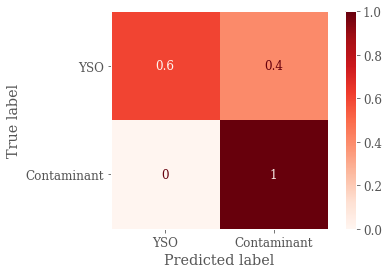

In [21]:
tar_va = CC_Webb_Classified.dropna(subset='SPICY_Class_0/1')[['SPICY_Class_0/1']].values.astype(int)
pred_va = CC_Webb_Classified.dropna(subset='SPICY_Class_0/1')[['Class']].values
ConfusionMatrixDisplay.from_predictions(tar_va,pred_va,cmap='Reds',display_labels=['YSO', 'Contaminant'],normalize='true')
print(f1_score(tar_va,pred_va))
print(classification_report(tar_va,pred_va))
plt.grid(False)
plt.savefig('CM_va_PRF_SPICY_Dec82022.png',dpi=300,facecolor=fig.get_facecolor())

Set DATE-AVG to '2022-06-03T12:45:26.346' from MJD-AVG.
Set DATE-END to '2022-06-03T15:22:38.772' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.574327 from OBSGEO-[XYZ].
Set OBSGEO-H to 1654444171.915 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


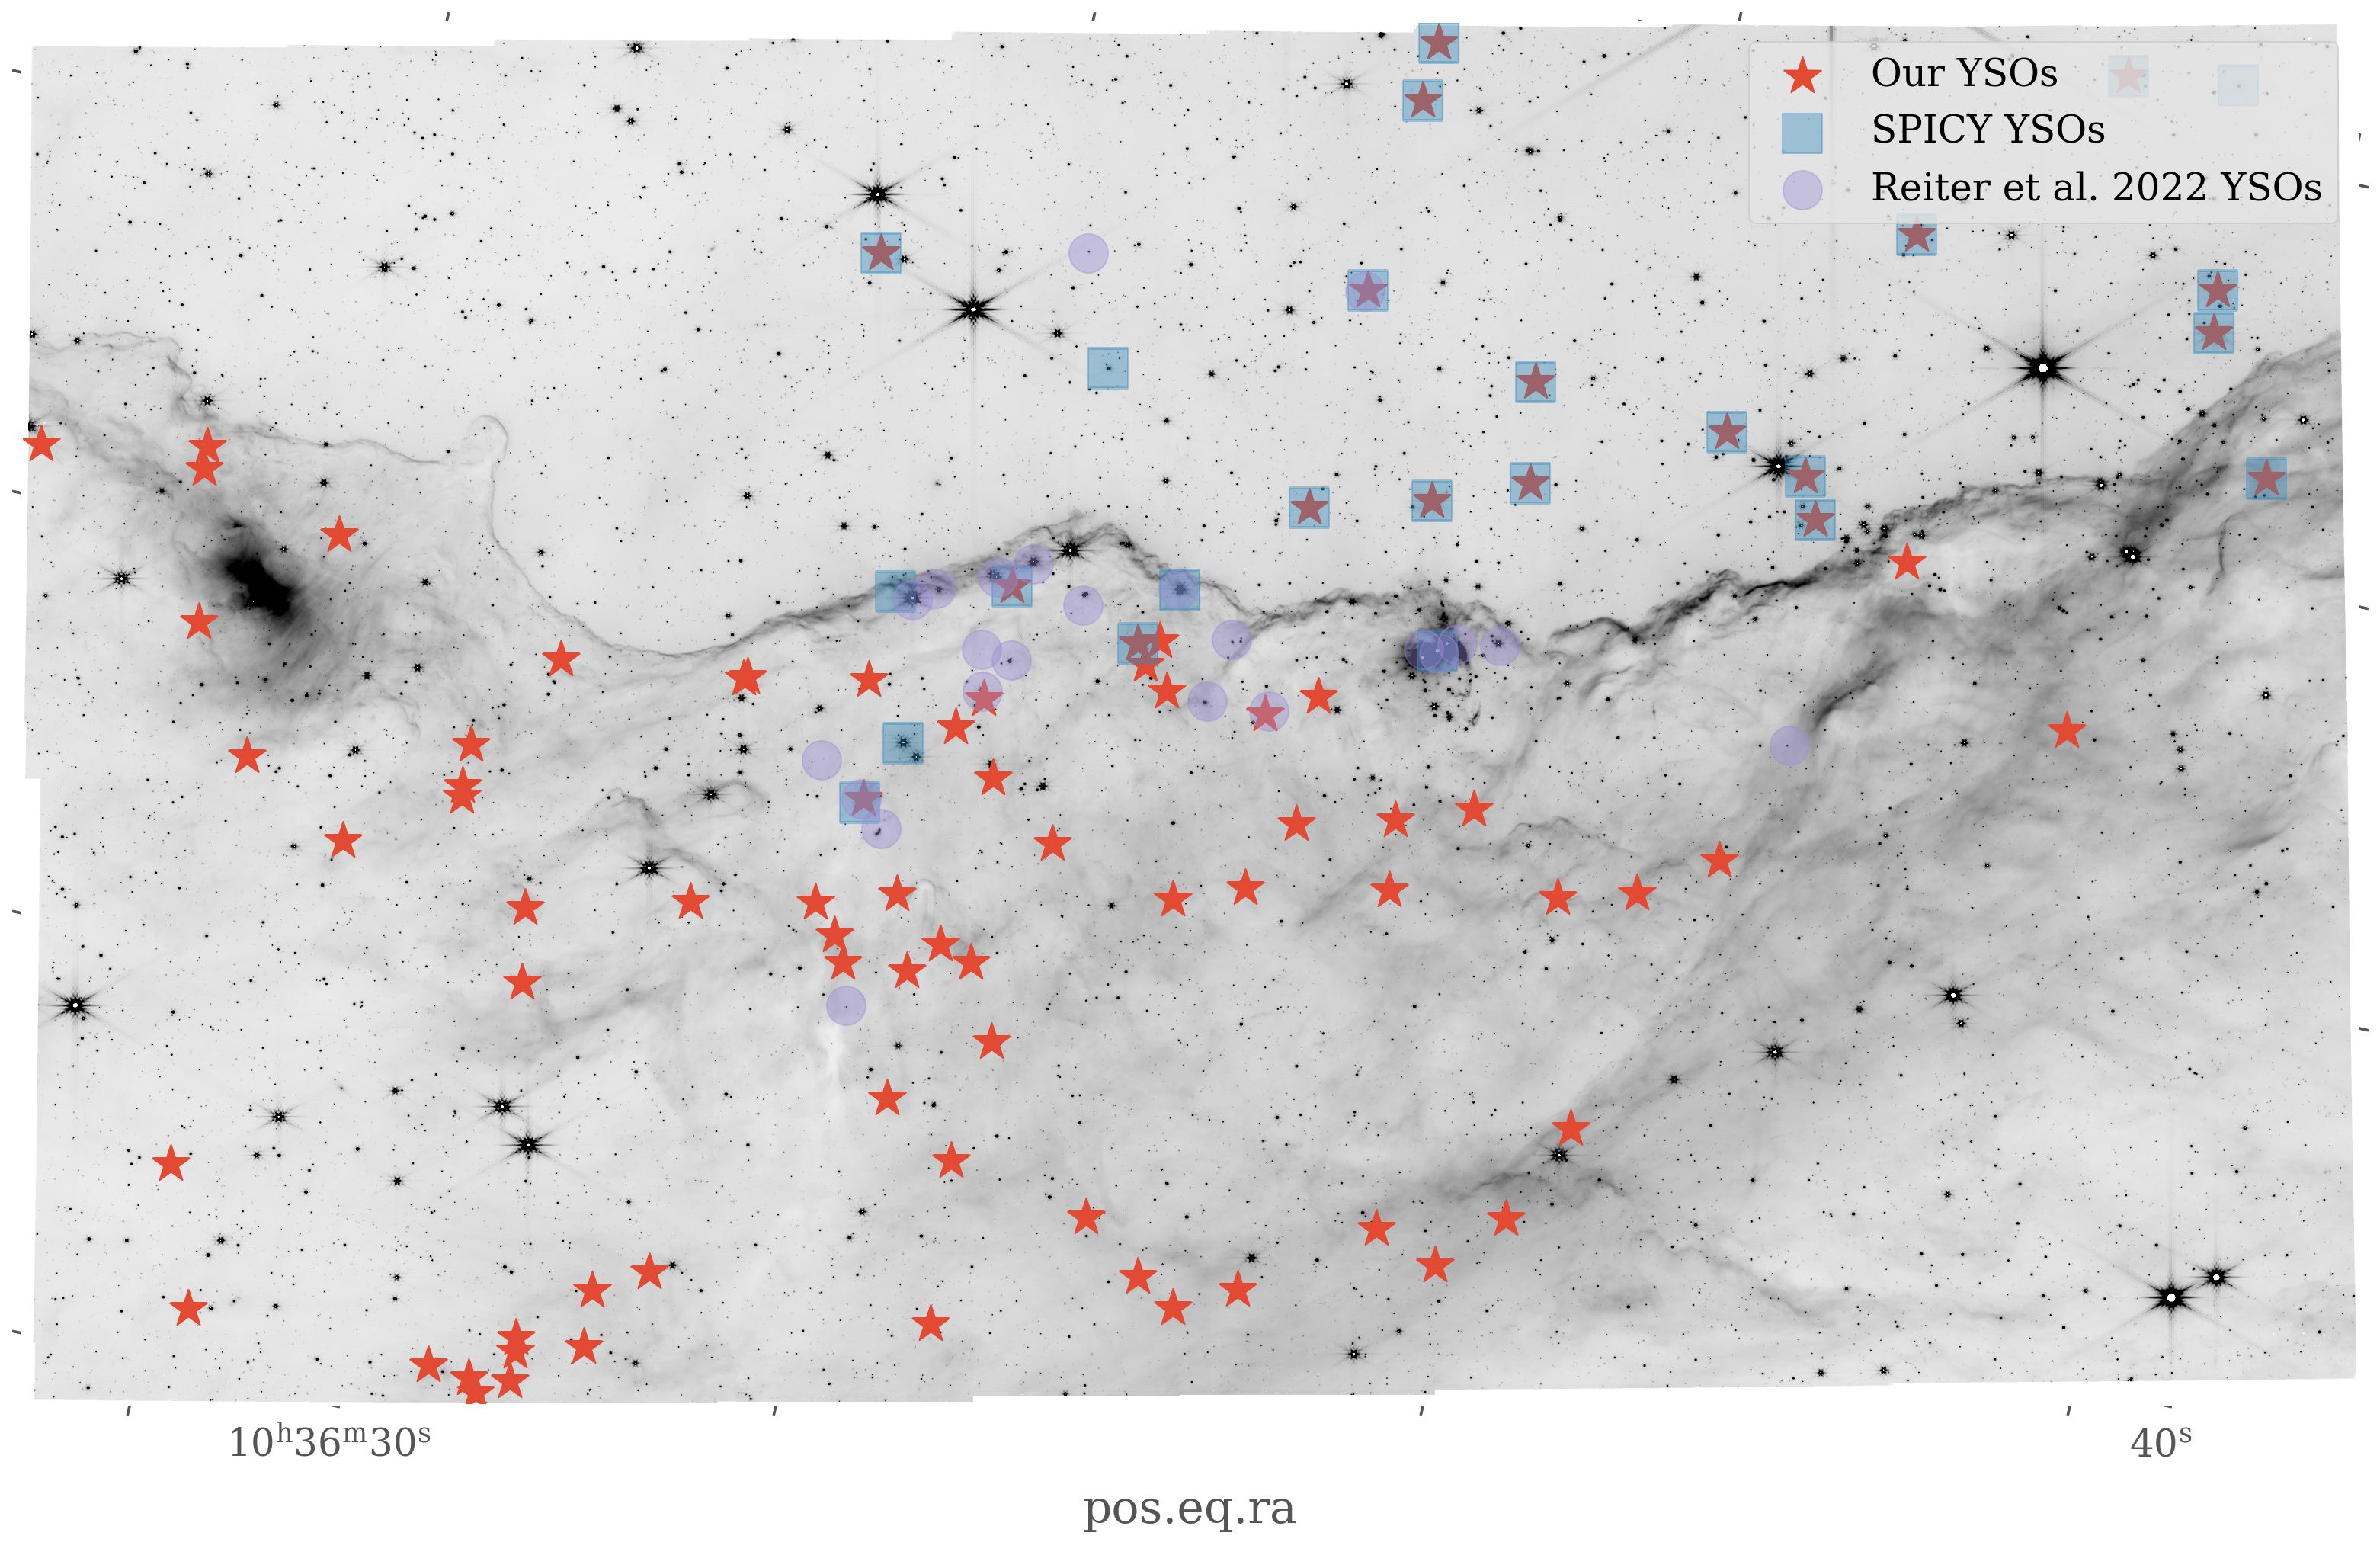

In [16]:
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import astropy.units as u


# Plot image
filter = "f444w"
image_file = f"../../../ngc3324/FITS/JWST_{filter}.fits"


h = fits.getheader(image_file)
f = fits.open(image_file)
wcs = WCS(f[1].header)
# plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(14,8),dpi=300)
ax = plt.subplot(projection=wcs)
plt.grid(color='white', ls='solid')
plt.imshow(f[1].data,cmap='gray_r',vmin=0,vmax=20,origin='lower') #vmax =1500 for f1800w
ymax, ymin = ax.get_ylim()
xmax, xmin = ax.get_xlim()
# plt.colorbar()

# ras, decs = wcs.wcs_pix2world(np.linspace(-500,15000,100), np.linspace(-500,16000,100), 1)
# print(min(ras))



reit = ["10:36:42.3 -58:38:04", "10:36:48.0 -58:38:19", "10:36:47.3 -58:38:10", "10:36:46.7 -58:38:05", "10:36:51.5 -58:37:54", "10:36:50.5 -58:37:52",\
    "10:36:51.4 -58:37:48", "10:36:53.8 -58:37:48", "10:36:51.5 -58:37:10", "10:36:54.2 -58:36:26", "10:36:54.4 -58:36:18", "10:36:54.0 -58:37:20",\
        "10:36:53.6 -58:35:20", "10:36:53.1 -58:37:37", "10:36:53.3 -58:37:54", "10:36:52.7 -58:38:05", "10:36:53.1 -58:37:08", "10:36:51.6 -58:36:58",\
        "10:36:52.3 -58:38:09", "10:36:53.9 -58:36:29", "10:37:01.5 -58:37:51", "10:37:02.1 -58:36:58", "10:36:53.9 -58:36:32"]# End of third row is the end of MHO-only sources
sky_1 = SkyCoord(reit,unit=(u.hourangle, u.deg))
ra_1 = sky_1.ra
dec_1 = sky_1.dec

# reit_eg = ["10:36:53.7 -58:35:47", "10:36:59.5 -58:39:01", "10:37:07.2 -58:35:36", "10:36:55.2 -58:38:09"]
# sky_1 = SkyCoord(reit_eg,unit=(u.hourangle, u.deg))
# ra_eg = sky_1.ra
# dec_eg = sky_1.dec

ra_spicy = CC_Webb_Classified.RA.values[CC_Webb_Classified['SPICY_Class_0/1']==0]
dec_spicy = CC_Webb_Classified.DEC.values[CC_Webb_Classified['SPICY_Class_0/1']==0]


ra_yso = CC_Webb_Classified.RA.values[CC_Webb_Classified.Class == 0]
dec_yso = CC_Webb_Classified.DEC.values[CC_Webb_Classified.Class == 0]

plt.scatter(ra_yso,dec_yso, marker='*', s=150,transform=ax.get_transform('fk5'),label='Our YSOs')
plt.scatter(ra_spicy,dec_spicy, marker='s',s=150, alpha=0.4,transform=ax.get_transform('fk5'),label='SPICY YSOs')
plt.scatter(ra_1,dec_1, marker='o',s=150, alpha=0.4,transform=ax.get_transform('fk5'),label='Reiter et al. 2022 YSOs')
ax.set_ylim(ymax, ymin)
ax.set_xlim(xmax, xmin)
plt.legend(loc=1)
ax.grid(False)
# plt.xticks()
# plt.yticks()
# plt.xlabel('RA')
# plt.ylabel('DEC')

plt.savefig(f"CC_w_Reiter_SPICYtr_Label_{filter}.png",dpi=300)


In [41]:
a = CC_Webb_Classified[CC_Webb_Classified.Class==0][CC_Webb_Classified['SPICY_Class_0/1']==0].index # Correctly classified as YSO
b = CC_Webb_Classified[CC_Webb_Classified.Class==0][CC_Webb_Classified['SPICY_Class_0/1']==1].index # Incorrectly classified as YSO
c = CC_Webb_Classified[CC_Webb_Classified.Class!=0][CC_Webb_Classified['SPICY_Class_0/1']==0].index # Incorrectly classified as Star
d = CC_Webb_Classified[CC_Webb_Classified.Class!=0][CC_Webb_Classified['SPICY_Class_0/1']==1].index # Correctly classified as Star


/var/folders/qy/7yz8bmv96hx8rndql_rfdz_80000gn/T/ipykernel_44645/3283703603.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  a = CC_Webb_Classified[CC_Webb_Classified.Class==0][CC_Webb_Classified['SPICY_Class_0/1']==0].index # Correctly classified as YSO
/var/folders/qy/7yz8bmv96hx8rndql_rfdz_80000gn/T/ipykernel_44645/3283703603.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  b = CC_Webb_Classified[CC_Webb_Classified.Class==0][CC_Webb_Classified['SPICY_Class_0/1']==1].index # Incorrectly classified as YSO
/var/folders/qy/7yz8bmv96hx8rndql_rfdz_80000gn/T/ipykernel_44645/3283703603.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  c = CC_Webb_Classified[CC_Webb_Classified.Class!=0][CC_Webb_Classified['SPICY_Class_0/1']==0].index # Incorrectly classified as Star
/var/folders/qy/7yz8bmv96hx8rndql_rfdz_80000gn/T/ipykernel_44645/3283703603.py:4: UserWarning: Boolean Series key will be rei

-1.1562484324500528


(array([  1.,   0.,   0.,   0.,   2.,   1.,   5.,  61., 156., 110.]),
 array([-8.02814343, -7.21956705, -6.41099066, -5.60241428, -4.7938379 ,
        -3.98526151, -3.17668513, -2.36810875, -1.55953236, -0.75095598,
         0.0576204 ]),
 <BarContainer object of 10 artists>)

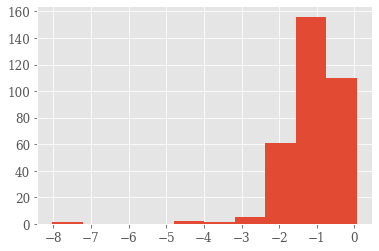

In [42]:
diffs = all_inp.mag_IR2-all_inp.isophotal_vegamag_f444w
print(np.nanmean(diffs))
plt.hist(diffs)

In [43]:
# mu_a = pd.DataFrame([CC_Webb_Classified.iloc[a].mean(skipna=True)])
# sig_a = pd.DataFrame([CC_Webb_Classified.iloc[a].std(skipna=True)])

# mu_b = CC_Webb_Classified.iloc[b].mean()
# sig_b = CC_Webb_Classified.iloc[b].std()

# mu_c = CC_Webb_Classified.iloc[c].mean()
# sig_c = CC_Webb_Classified.iloc[c].std()

# mu_d = CC_Webb_Classified.iloc[d].mean()
# sig_d = CC_Webb_Classified.iloc[d].std()
# print(mu_a)
def sed_plot_mu(ax, ind, cat,title=None,correction=0):
    mu = pd.DataFrame([cat.iloc[ind].mean(skipna=True)])
    sig = pd.DataFrame([cat.iloc[ind].std(skipna=True)])
    # chi2 = chisquare((cat.iloc[ind]+correction).to_numpy()[~np.isnan(cat.iloc[ind]+correction).to_numpy()],np.array(mu)[~np.isnan(np.array(mu))])
    # fig, ax = plt.subplots(figsize=(12,6),dpi=100)
    plt.rcParams['font.size'] = 12
    plt.rcParams['font.family'] = 'serif'
    plt.style.use('ggplot')
    plt.gca().invert_yaxis()

    kwargs = {
        'marker': 'o',
        # 'linestyle': '-.',
        'alpha': 0.2
    }

    webb_bands = [idx for idx in mu.columns.values if (idx[:14].lower() == 'isophotal_vega' and (idx[-9:-6] != 'err' and idx[-15:-12] != 'err'and idx[-10:-7] != 'err'))]
    webb_mic = [int(webb_bands[i].split('f')[-1][:-1])/100 for i in np.arange(0,len(webb_bands))]

    spitz2m_bands = [idx for idx in mu.columns.values if (idx[:3].lower() == 'mag')]
    spitz_mic = [1.235,1.662,2.159,3.6,4.5,5.8,8.0]
    maxes = cat[spitz2m_bands].max().to_numpy()

    all_mic = list(np.r_[webb_mic,spitz_mic]) # Collect list of values for xticks
    del all_mic[4] 
    del all_mic[2]
    del all_mic[1]# Delete the xtick label of 4.44 to avoid over crowding

    ax.plot(np.array([webb_mic]*len(cat.iloc[ind])).transpose(),(cat.iloc[ind][webb_bands].to_numpy()+correction).transpose(),'--',c='r',alpha=0.7)
    ax.plot(webb_mic,mu[webb_bands].to_numpy()[0]+correction,**kwargs,c='r',label='Webb SED')
    ax.fill_between(webb_mic,mu[webb_bands].to_numpy()[0]+correction-sig[webb_bands].to_numpy()[0],mu[webb_bands].to_numpy()[0]+correction+sig[webb_bands].to_numpy()[0],color='r',alpha=0.1)
    ax.plot(np.array([spitz_mic]*len(cat.iloc[ind])).transpose(),(cat.iloc[ind][spitz2m_bands].to_numpy()+correction).transpose(),'--',c='b',alpha=0.5)
    ax.plot(spitz_mic,mu[spitz2m_bands].to_numpy()[0],**kwargs, c='b',label='Spitzer/2MASS SED')
    ax.fill_between(spitz_mic,mu[spitz2m_bands].to_numpy()[0]-sig[spitz2m_bands].to_numpy()[0],mu[spitz2m_bands].to_numpy()[0]+sig[spitz2m_bands].to_numpy()[0],color='b',alpha=0.1)
    ax.plot([],[],alpha=0,label=f'Number: {len(ind)}')
    # ax.plot(spitz_mic,maxes,marker='x',c='b',markersize=10,label='Noise Values')
    # ax.set_xticks(all_mic)
    # plt.plot(label=f'$\chi$ Squared: {chi2}')
    # plt.legend(facecolor='darkgrey', framealpha=1,loc='lower right')
    # plt.xticks(all_mic)
    # plt.setp(ax.get_xticklabels(), rotation=60, horizontalalignment='right')
    # ax.set_xlabel('Wavelength')
    # ax.set_ylabel('Magnitude (Vega)')
    ax.set_title(title,c='k')

    return ax


/var/folders/qy/7yz8bmv96hx8rndql_rfdz_80000gn/T/ipykernel_44645/2113043115.py:14: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mu = pd.DataFrame([cat.iloc[ind].mean(skipna=True)])
/var/folders/qy/7yz8bmv96hx8rndql_rfdz_80000gn/T/ipykernel_44645/2113043115.py:15: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  sig = pd.DataFrame([cat.iloc[ind].std(skipna=True)])
/var/folders/qy/7yz8bmv96hx8rndql_rfdz_80000gn/T/ipykernel_44645/2113043115.py:14: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.

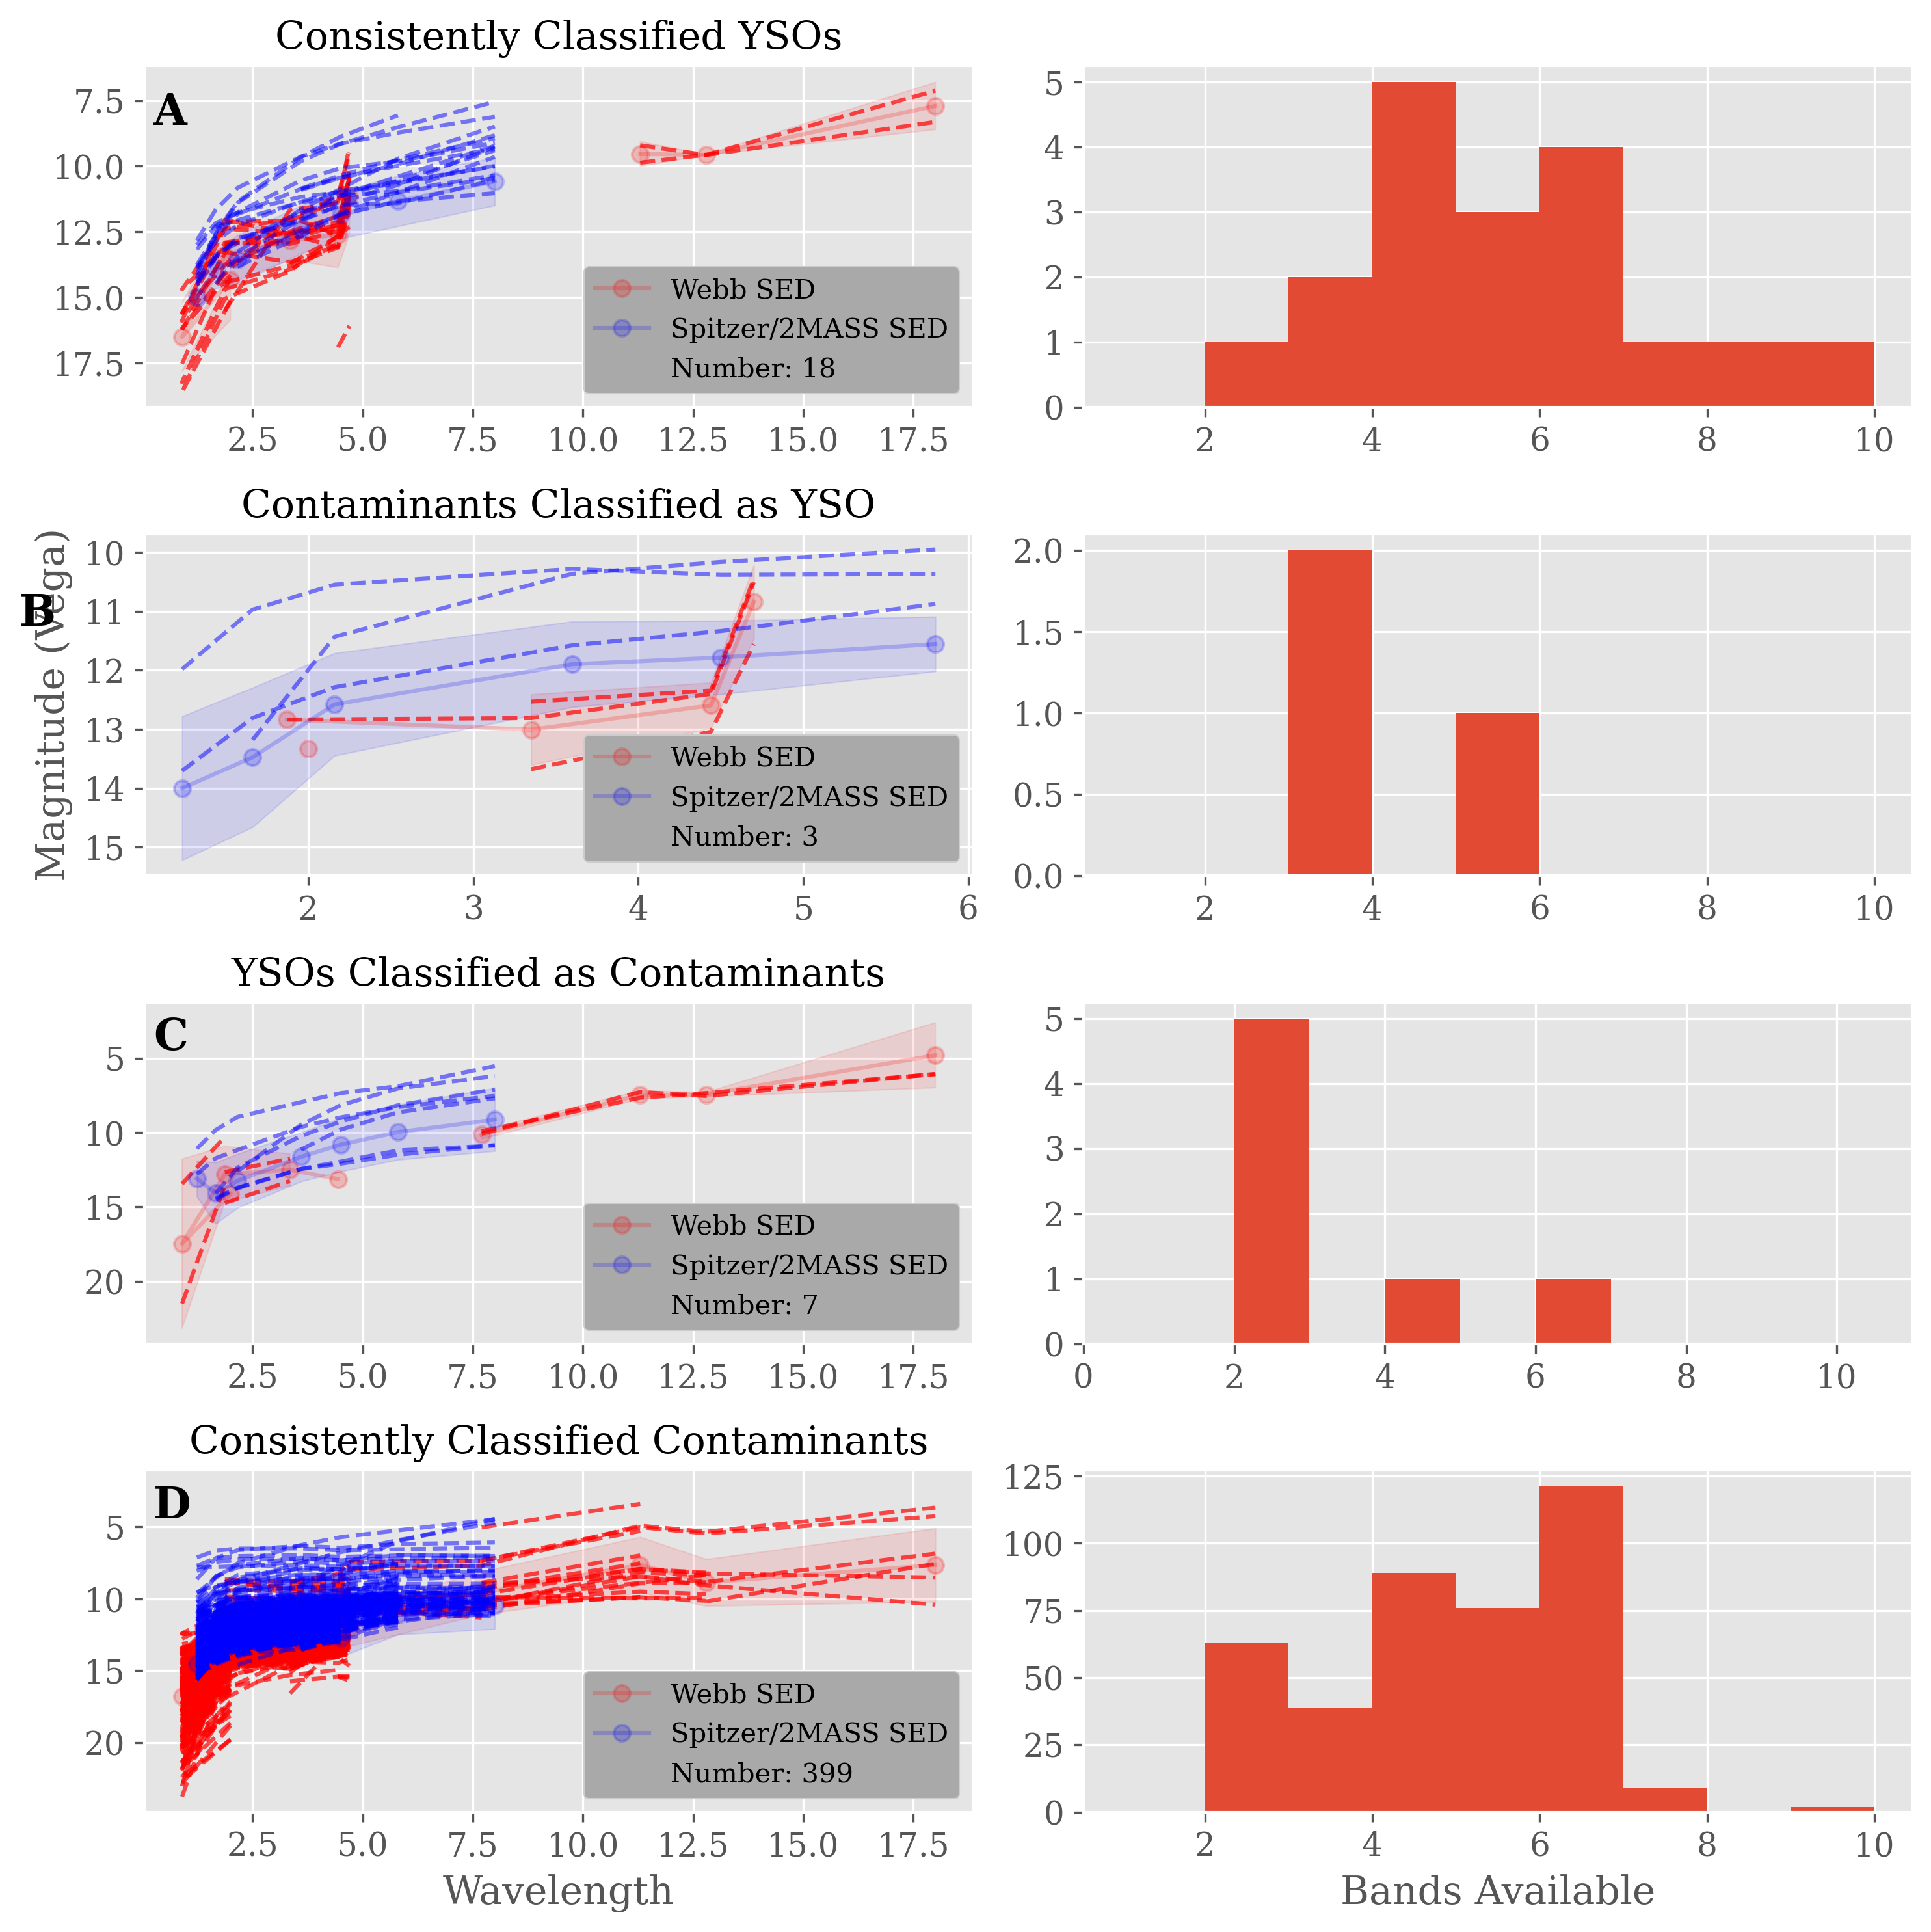

In [44]:
webb_bands = [idx for idx in CC_Webb_Classified.columns.values if (idx[:14].lower() == 'isophotal_vega' and (idx[-9:-6] != 'err' and idx[-15:-12] != 'err'and idx[-10:-7] != 'err'))]
    
fig, axs = plt.subplots(4,2,figsize=(10,10),dpi=300)

plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = 'serif'
plt.style.use('ggplot')
plt.tight_layout()
fig.set_tight_layout(True)
# subfigs = fig.subfigures(1, 2)

axs[0][0].invert_yaxis()
axs[1][0].invert_yaxis()
axs[2][0].invert_yaxis()
axs[3][0].invert_yaxis()
# axs[3][1].invert_yaxis()
axs[0][0] = sed_plot_mu(axs[0][0],a,CC_Webb_Classified,title='Consistently Classified YSOs',correction=np.nanmean(diffs))
axs[1][0] = sed_plot_mu(axs[1][0],b,CC_Webb_Classified,title='Contaminants Classified as YSO',correction=np.nanmean(diffs))
axs[2][0] = sed_plot_mu(axs[2][0],c,CC_Webb_Classified,title='YSOs Classified as Contaminants',correction=np.nanmean(diffs))
axs[3][0] = sed_plot_mu(axs[3][0],d,CC_Webb_Classified,title='Consistently Classified Contaminants',correction=np.nanmean(diffs))

ylim_a = axs[0][0].get_ylim()[1]
ylim_b = axs[1][0].get_ylim()[1]
ylim_c = axs[2][0].get_ylim()[1]
ylim_d = axs[3][0].get_ylim()[1]
axs[0][0].text(0.25, ylim_a+1, 'A',  fontsize=16, fontweight='bold', va='top',c='k')
axs[1][0].text(0.25, ylim_b+1, 'B',  fontsize=16, fontweight='bold', va='top',c='k')
axs[2][0].text(0.25, ylim_c+1, 'C',  fontsize=16, fontweight='bold', va='top',c='k')
axs[3][0].text(0.25, ylim_d+1, 'D',  fontsize=16, fontweight='bold', va='top',c='k')


axs[0][0].legend(facecolor='darkgrey', framealpha=1,loc='lower right')
axs[1][0].legend(facecolor='darkgrey', framealpha=1,loc='lower right')
axs[2][0].legend(facecolor='darkgrey', framealpha=1,loc='lower right')
axs[3][0].legend(facecolor='darkgrey', framealpha=1,loc='lower right')
plt.setp(ax.get_xticklabels(), rotation=60, horizontalalignment='right')
axs[3][0].set_xlabel('Wavelength')
axs[1][0].set_ylabel('Magnitude (Vega)')


axs[0][1].hist([np.count_nonzero(~CC_Webb_Classified[webb_bands].iloc[i].isna()) for i in a],bins=np.arange(1,11,1))
axs[1][1].hist([np.count_nonzero(~CC_Webb_Classified[webb_bands].iloc[i].isna()) for i in b],bins=np.arange(1,11,1))
axs[2][1].hist([np.count_nonzero(~CC_Webb_Classified[webb_bands].iloc[i].isna()) for i in c],bins=np.arange(1,11,1))
axs[3][1].hist([np.count_nonzero(~CC_Webb_Classified[webb_bands].iloc[i].isna()) for i in d],bins=np.arange(1,11,1))
axs[2][1].set_xlim(0,11)
axs[3][1].set_xlabel('Bands Available')

plt.savefig('seds.png',dpi=300)

In [45]:
CC_Webb_Classified.columns
# CC_Webb_Classified[spitzer_bands].div(CC_Webb_Classified.mag_IR2,axis=0)

Index(['RA', 'DEC', 'size', 'isophotal_vegamag_f200w',
       'isophotal_vegamag_err_f200w', 'isophotal_vegamag_f090w',
       'isophotal_vegamag_err_f090w', 'isophotal_vegamag_f187n',
       'isophotal_vegamag_err_f187n', 'isophotal_vegamag_f335m',
       'isophotal_vegamag_err_f335m', 'isophotal_vegamag_f444w',
       'isophotal_vegamag_err_f444w', 'isophotal_vegamag_f444w-f470n',
       'isophotal_vegamag_err_f444w-f470n', 'isophotal_vegamag_f770w',
       'isophotal_vegamag_err_f770w', 'isophotal_vegamag_f1130w',
       'isophotal_vegamag_err_f1130w', 'isophotal_vegamag_f1280w',
       'isophotal_vegamag_err_f1280w', 'isophotal_vegamag_f1800w',
       'isophotal_vegamag_err_f1800w', 'Class', 'Prob YSO', 'mag_J', 'e_mag_J',
       'mag_H', 'e_mag_H', 'mag_Ks', 'e_mag_Ks', 'mag_IR1', 'e_mag_IR1',
       'mag_IR2', 'e_mag_IR2', 'mag_IR3', 'e_mag_IR3', 'mag_IR4', 'e_mag_IR4',
       'SPICY_Class_0/1', 'SPICY', 'SPICY_Class'],
      dtype='object')

In [46]:
CC_Webb_Classified_normed = pd.DataFrame()
print((CC_Webb_Classified[webb_bands].div(CC_Webb_Classified.isophotal_vegamag_f444w,axis=0).shape))
# print((CC_Webb_Classified_normed[webb_bands]).shape)
CC_Webb_Classified_normed[webb_bands] = CC_Webb_Classified[webb_bands].div(CC_Webb_Classified.isophotal_vegamag_f444w,axis=0)
CC_Webb_Classified_normed[spitzer_bands[:-3]] = CC_Webb_Classified[spitzer_bands[:-3]].div(CC_Webb_Classified.mag_IR2,axis=0)
CC_Webb_Classified_normed[['SPICY_Class_0/1', 'SPICY','SPICY_Class']] = CC_Webb_Classified[['SPICY_Class_0/1', 'SPICY','SPICY_Class']]
CC_Webb_Classified_normed

(8619, 10)


isophotal_vegamag_f200w  isophotal_vegamag_f090w  \
0                         NaN                      NaN   
1                         NaN                      NaN   
2                         NaN                      NaN   
3                    1.369671                      NaN   
4                         NaN                      NaN   
...                       ...                      ...   
8614                      NaN                      NaN   
8615                      NaN                      NaN   
8616                      NaN                      NaN   
8617                      NaN                      NaN   
8618                      NaN                      NaN   

      isophotal_vegamag_f187n  isophotal_vegamag_f335m  \
0                         NaN                      NaN   
1                         NaN                      NaN   
2                         NaN                      NaN   
3                         NaN                 0.880484   
4                         NaN                      NaN   
...                       ...                      ...   
8614                      NaN                      NaN   
8615                      NaN                      NaN   
8616                      NaN                      NaN   
8617                      NaN                      NaN   
8618                      NaN                      NaN   

      isophotal_vegamag_f444w  isophotal_vegamag_f444w-f470n  \
0                         NaN                            NaN   
1                         NaN                            NaN   
2                         NaN                            NaN   
3                         1.0                       1.001968   
4                         NaN                            NaN   
...                       ...                            ...   
8614                      NaN                            NaN   
8615                      NaN                            NaN   
8616                      NaN                            NaN   
8617                      NaN                            NaN   
8618                      NaN                            NaN   

      isophotal_vegamag_f770w  isophotal_vegamag_f1130w  \
0                         NaN                       NaN   
1                         NaN                       NaN   
2                         NaN                       NaN   
3                    0.559103                       NaN   
4                         NaN                       NaN   
...                       ...                       ...   
8614                      NaN                       NaN   
8615                      NaN                       NaN   
8616                      NaN                       NaN   
8617                      NaN                       NaN   
8618                      NaN                       NaN   

      isophotal_vegamag_f1280w  isophotal_vegamag_f1800w  ... e_mag_IR1  \
0                          NaN                       NaN  ...       NaN   
1                          NaN                       NaN  ...       NaN   
2                          NaN                       NaN  ...       NaN   
3                          NaN                  0.606737  ...       NaN   
4                          NaN                       NaN  ...       NaN   
...                        ...                       ...  ...       ...   
8614                       NaN                       NaN  ...  0.006155   
8615                       NaN                       NaN  ...       NaN   
8616                       NaN                       NaN  ...       NaN   
8617                       NaN                       NaN  ...       NaN   
8618                       NaN                       NaN  ...       NaN   

     mag_IR2 e_mag_IR2 mag_IR3 e_mag_IR3 mag_IR4 e_mag_IR4 SPICY_Class_0/1  \
0        NaN       NaN     NaN       NaN     NaN       NaN             NaN   
1        NaN       NaN     NaN       NaN     NaN       NaN             NaN   

/var/folders/qy/7yz8bmv96hx8rndql_rfdz_80000gn/T/ipykernel_44645/2113043115.py:14: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mu = pd.DataFrame([cat.iloc[ind].mean(skipna=True)])
/var/folders/qy/7yz8bmv96hx8rndql_rfdz_80000gn/T/ipykernel_44645/2113043115.py:15: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  sig = pd.DataFrame([cat.iloc[ind].std(skipna=True)])
/var/folders/qy/7yz8bmv96hx8rndql_rfdz_80000gn/T/ipykernel_44645/2113043115.py:14: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.

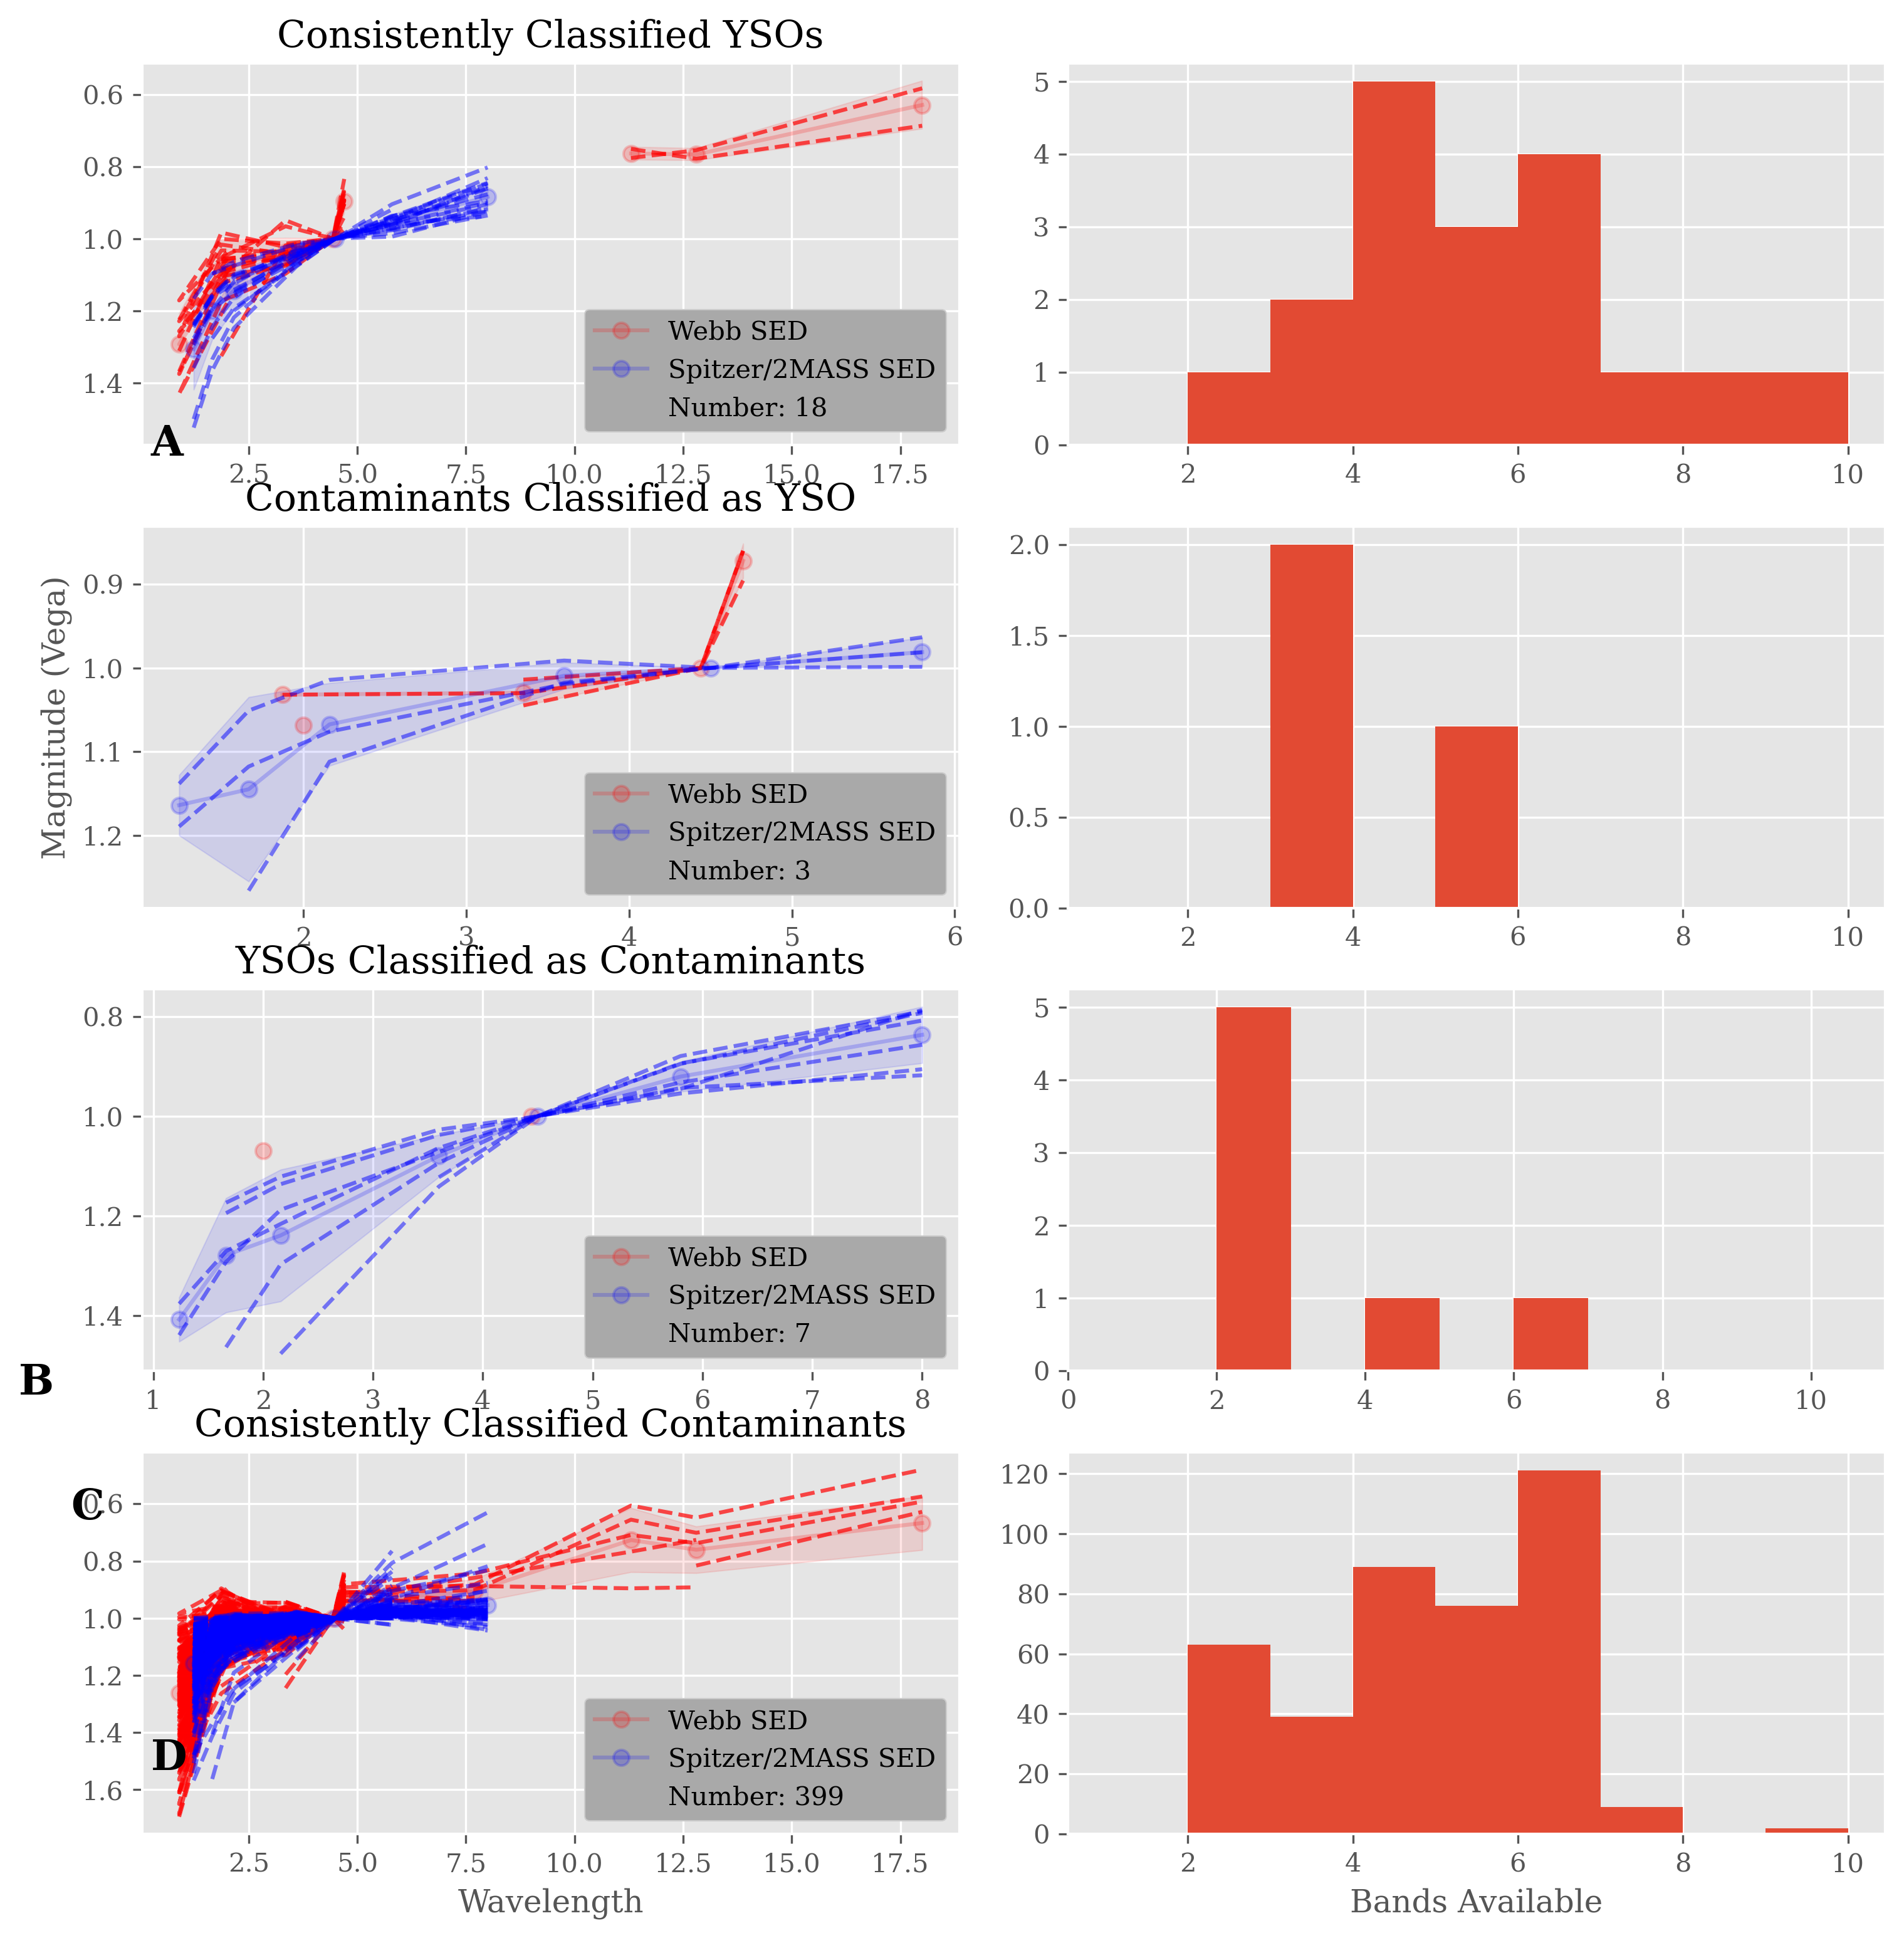

In [47]:
# Normalize to 4.5/4.44 μm

# Plot again
fig, axs = plt.subplots(4,2,figsize=(10,10),dpi=300)

plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = 'serif'
plt.style.use('ggplot')
plt.tight_layout()
fig.set_tight_layout(True)
# subfigs = fig.subfigures(1, 2)

axs[0][0].invert_yaxis()
axs[1][0].invert_yaxis()
axs[2][0].invert_yaxis()
axs[3][0].invert_yaxis()
# axs[3][1].invert_yaxis()
axs[0][0] = sed_plot_mu(axs[0][0],a,CC_Webb_Classified_normed,title='Consistently Classified YSOs')
axs[1][0] = sed_plot_mu(axs[1][0],b,CC_Webb_Classified_normed,title='Contaminants Classified as YSO')
axs[2][0] = sed_plot_mu(axs[2][0],c,CC_Webb_Classified_normed,title='YSOs Classified as Contaminants')
axs[3][0] = sed_plot_mu(axs[3][0],d,CC_Webb_Classified_normed,title='Consistently Classified Contaminants')

ylim_a = axs[0][0].get_ylim()[1]
ylim_b = axs[1][0].get_ylim()[1]
ylim_c = axs[2][0].get_ylim()[1]
ylim_d = axs[3][0].get_ylim()[1]
axs[0][0].text(0.25, ylim_a+1, 'A',  fontsize=16, fontweight='bold', va='top',c='k')
axs[1][0].text(0.25, ylim_b+1, 'B',  fontsize=16, fontweight='bold', va='top',c='k')
axs[2][0].text(0.25, ylim_c+1, 'C',  fontsize=16, fontweight='bold', va='top',c='k')
axs[3][0].text(0.25, ylim_d+1, 'D',  fontsize=16, fontweight='bold', va='top',c='k')


axs[0][0].legend(facecolor='darkgrey', framealpha=1,loc='lower right')
axs[1][0].legend(facecolor='darkgrey', framealpha=1,loc='lower right')
axs[2][0].legend(facecolor='darkgrey', framealpha=1,loc='lower right')
axs[3][0].legend(facecolor='darkgrey', framealpha=1,loc='lower right')
plt.setp(ax.get_xticklabels(), rotation=60, horizontalalignment='right')
axs[3][0].set_xlabel('Wavelength')
axs[1][0].set_ylabel('Magnitude (Vega)')


axs[0][1].hist([np.count_nonzero(~CC_Webb_Classified[webb_bands].iloc[i].isna()) for i in a],bins=np.arange(1,11,1))
axs[1][1].hist([np.count_nonzero(~CC_Webb_Classified[webb_bands].iloc[i].isna()) for i in b],bins=np.arange(1,11,1))
axs[2][1].hist([np.count_nonzero(~CC_Webb_Classified[webb_bands].iloc[i].isna()) for i in c],bins=np.arange(1,11,1))
axs[3][1].hist([np.count_nonzero(~CC_Webb_Classified[webb_bands].iloc[i].isna()) for i in d],bins=np.arange(1,11,1))
axs[2][1].set_xlim(0,11)
axs[3][1].set_xlabel('Bands Available')

plt.savefig('seds_norm.png',dpi=300)

## Table of SPICY Labels, JWST_NUM, Reiter matched

In [48]:
# JWST_NUM

# print('J'+np.array(jwst_spitz_cat.RA)+np.array(jwst_spitz_cat.DEC))
def deg_to_hrminsec(deg):
    deg = deg*u.deg
    h = deg.to(u.hourangle)/u.hourangle
    m = (h%1)*60
    s = (m%1)*60
    return str(int(h))+"{:02d}".format(int(m))+"{:04.1f}".format(s)
def deghr_to_hrminsec(deg):
    h = deg
    # print(Angle(deg,u.hourangle).hms)
    m = 60-(h%1)*60
    s = (m%1)*60
    return str(int(h))+"{:02d}".format(int(m))+"{:02d}".format(int(s))

jwst_num = []


for i, r in enumerate(np.array(CC_Webb_Classified.RA)):
    jwst_num.append('J'+deg_to_hrminsec(r)+deghr_to_hrminsec(np.array(CC_Webb_Classified.DEC)[i]))

CC_Webb_Classified["JWST_NUM"] = jwst_num

In [49]:
CC_Webb_Classified.dropna(subset='SPICY')[['SPICY','RA','DEC','JWST_NUM','Class','SPICY_Class']].sort_values('SPICY')

SPICY          RA        DEC          JWST_NUM  Class SPICY_Class
40    7423.0  159.196619 -58.636155  J103647.2-583810    1.0   ClassI   
48    7428.0  159.203493 -58.634591  J103648.8-583804    1.0   ClassII  
75    7434.0  159.218346 -58.636769  J103652.4-583812    1.0   ClassI   
61    7435.0  159.218698 -58.623664  J103652.5-583725    0.0   ClassI   
2677  7438.0  159.221523 -58.630829  J103653.2-583750    0.0   uncertain
4799  7440.0  159.224778 -58.608155  J103653.9-583629    1.0   FS       
4825  7441.0  159.224978 -58.622141  J103654.0-583719    1.0   ClassI   
367   7444.0  159.236006 -58.616442  J103656.6-583659    0.0   ClassII  
261   7447.0  159.239484 -58.610174  J103657.5-583636    0.0   ClassII  
70    7448.0  159.243400 -58.605343  J103658.4-583619    0.0   FS       
3822  7452.0  159.245307 -58.628435  J103658.9-583742    1.0   ClassII  
342   7454.0  159.246256 -58.590204  J103659.1-583524    0.0   FS       
293   7461.0  159.250350 -58.591211  J103700.1-583528    0.0   FS       
333   7462.0  159.251562 -58.641508  J103700.4-583829    0.0   ClassII  
72    7464.0  159.252949 -58.595799  J103700.7-583544    0.0   ClassII  
88    7465.0  159.253583 -58.606255  J103700.9-583622    0.0   FS       
463   7467.0  159.258837 -58.615969  J103702.1-583657    0.0   ClassII  
276   7469.0  159.260493 -58.567426  J103702.5-583402    0.0   ClassI   
267   7473.0  159.273686 -58.571841  J103705.7-583418    0.0   FS       
288   7475.0  159.276770 -58.588341  J103706.4-583518    0.0   ClassII  
284   7476.0  159.278009 -58.572147  J103706.7-583419    0.0   ClassII  
332   7477.0  159.278908 -58.615365  J103706.9-583655    0.0   ClassII  
330   7479.0  159.284973 -58.615232  J103708.4-583654    0.0   ClassII  
286   7481.0  159.297223 -58.579272  J103711.3-583445    0.0   ClassII  
4290  7482.0  159.298754 -58.573496  J103711.7-583424    1.0   ClassII

In [50]:
len(np.unique(CC_Webb_Classified.dropna(subset='SPICY')[['SPICY']]))

25

In [51]:
idx, sep2d, _ = match_coordinates_sky(sky_1,SkyCoord(CC_Webb_Classified.RA*u.deg, CC_Webb_Classified.DEC*u.deg))
print(np.sort(idx))
CC_Webb_Classified[['JWST_NUM','Class','SPICY_Class','SPICY']].iloc[idx]

[  43   58   75  145  236  275  324  463  950 1312 1687 1911 2677 3474
 3599 3634 3648 4159 4160 4799 4825 6798 6871]


JWST_NUM  Class SPICY_Class   SPICY
1911  J103642.3-583803    1.0         NaN     NaN
6798  J103648.0-583818    1.0         NaN     NaN
275   J103647.3-583809    0.0         NaN     NaN
3474  J103646.6-583805    1.0         NaN     NaN
6871  J103651.6-583756    1.0         NaN     NaN
58    J103650.5-583752    1.0         NaN     NaN
3634  J103651.4-583748    1.0         NaN     NaN
145   J103653.8-583748    1.0         NaN     NaN
3599  J103651.5-583710    1.0         NaN     NaN
4160  J103654.3-583625    1.0         NaN     NaN
4159  J103654.5-583618    1.0         NaN     NaN
4825  J103654.0-583719    1.0   ClassI     7441.0
1312  J103653.6-583520    1.0         NaN     NaN
324   J103653.4-583737    1.0         NaN     NaN
2677  J103653.2-583750    0.0   uncertain  7438.0
236   J103652.7-583803    1.0         NaN     NaN
3648  J103653.0-583707    1.0         NaN     NaN
1687  J103651.6-583657    1.0         NaN     NaN
75    J103652.4-583812    1.0   ClassI     7434.0
4799  J103653.9-583629    1.0   FS         7440.0
950   J103701.5-583750    1.0         NaN     NaN
463   J103702.1-583657    0.0   ClassII    7467.0
43    J103654.1-583630    1.0         NaN     NaN

## Probability of being a YSO cut vs recall/precision

In [20]:
CC_Webb_Classified = pd.read_csv('CC_Webb_Predictions_Prob_test.csv')

CC_Webb_Classified.columns

Index(['Unnamed: 0', 'RA', 'DEC', 'size', 'isophotal_vegamag_f200w',
       'isophotal_vegamag_err_f200w', 'isophotal_vegamag_f090w',
       'isophotal_vegamag_err_f090w', 'isophotal_vegamag_f187n',
       'isophotal_vegamag_err_f187n', 'isophotal_vegamag_f335m',
       'isophotal_vegamag_err_f335m', 'isophotal_vegamag_f444w',
       'isophotal_vegamag_err_f444w', 'isophotal_vegamag_f444w-f470n',
       'isophotal_vegamag_err_f444w-f470n', 'isophotal_vegamag_f770w',
       'isophotal_vegamag_err_f770w', 'isophotal_vegamag_f1130w',
       'isophotal_vegamag_err_f1130w', 'isophotal_vegamag_f1280w',
       'isophotal_vegamag_err_f1280w', 'isophotal_vegamag_f1800w',
       'isophotal_vegamag_err_f1800w', 'Class', 'Prob YSO', 'mag_J', 'e_mag_J',
       'mag_H', 'e_mag_H', 'mag_Ks', 'e_mag_Ks', 'mag_IR1', 'e_mag_IR1',
       'mag_IR2', 'e_mag_IR2', 'mag_IR3', 'e_mag_IR3', 'mag_IR4', 'e_mag_IR4',
       'SPICY_Class_0/1', 'SPICY', 'SPICY_Class'],
      dtype='object')

[0.54054054 0.95641026]
[0.6031746  0.96839444]
[0.65517241 0.97487437]
[0.67857143 0.97744361]
[0.7755102 0.9863354]
[0.75555556 0.98640297]
[0.76190476 0.98768473]
[0.75       0.98771499]
[0.71794872 0.98650307]
[0.64864865 0.98408813]
[0.         0.96984318]


/Users/breannacrompvoets/miniforge3/envs/SF/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


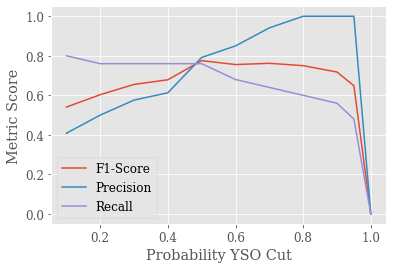

In [41]:
tar_va = CC_Webb_Classified.dropna(subset='SPICY_Class_0/1')[['SPICY_Class_0/1']].values.astype(int)
prob_yso = CC_Webb_Classified.dropna(subset='SPICY_Class_0/1')[['Prob YSO']].values
f1s = []
recs = []
pres = []
cuts = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,1]
for i in cuts:
    preds = np.array([1]*len(CC_Webb_Classified.dropna(subset='SPICY_Class_0/1')[['Class']].values))
    preds[np.where(prob_yso>i)[0]] = 0
    f1s.append(f1_score(tar_va,preds,average=None)[0])
    recs.append(recall_score(tar_va,preds,average=None)[0])
    pres.append(precision_score(tar_va,preds,average=None)[0])
    print(f1_score(tar_va,preds,average=None))


plt.plot(cuts,f1s,label='F1-Score')
plt.plot(cuts,pres,label='Precision')
plt.plot(cuts,recs,label='Recall')
plt.xlabel('Probability YSO Cut')
plt.ylabel('Metric Score')

plt.legend()

## Notes

kld - divergence metric

Keep 4.5-4.44

Don't forget mags are logarithmic, look at Jy 2.5log(J1/J2)